In [168]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary



from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/UCLA Fall 2024/[Shared] CS 260D Large Scale Machine Learning/Final Project'
data_path = rf'{drive_path}/data'

sys.path.append(drive_path) # Define the path in the Shared Drive

# Otherwise, define a local path in the current Colab working d|irectory
# data_path = './data'

# Check for GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure the local 'data' directory exists
os.makedirs(data_path, exist_ok=True)

# Download the MNIST dataset to the specified data path
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu


In [169]:
!pip install scikit-learn-extra
import numpy as np
import matplotlib.pyplot as plt

from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA

In [357]:
############################################
# FIND SUBSET SIZE
############################################
# Import necessary libraries
import pickle
import gzip
import os

train_dataset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
sample_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# unpack a bunch of examples
size_test_images = []
size_test_labels = []
for images, label_batch in sample_loader:
    for image in images:
      size_test_images.append(image)
    for label in label_batch:
      size_test_labels.append(label)
    # break

k = 150 # starting point just for visualizing, this takes a while to run
serialized_size = 0
compressed_size = 0
x = []
y_comp = []
y_uncomp = []

while compressed_size < 3: # size in MB
  sset = (size_test_labels[:k], size_test_images[:k]) # choose sset above
  # Serialize the data with gzip compression to reduce size
  serialized_data = pickle.dumps(sset)
  compressed_data = gzip.compress(serialized_data)

  # Calculate the size of the compressed serialized data
  serialized_size = len(serialized_data) / (1024 * 1024)  # Convert bytes to MB
  compressed_size = len(compressed_data) / (1024 * 1024)  # Convert bytes to MB
  x.append(k)

  y_uncomp.append(serialized_size)
  y_comp.append(compressed_size)# y_comp.append(compressed_size)
  k +=10

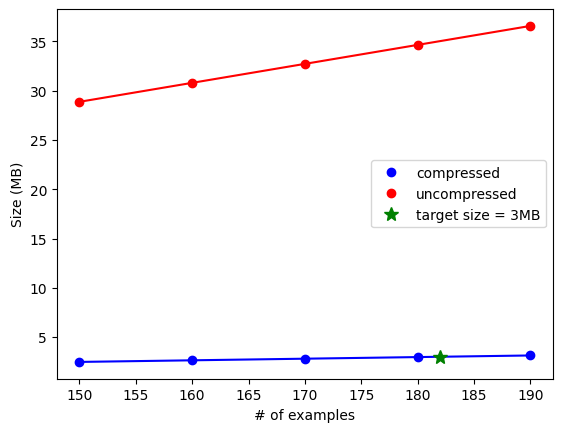

In [358]:
from scipy import stats
import numpy as np
# Now we have a linear regression for dataset size vs # of examples to extrapolate from
slope_comp, intercept_comp, r_comp, p_comp, std_err_comp = stats.linregress(x, y_comp)
plt.plot(x, y_comp, 'bo', label='compressed')
plt.plot(x, np.multiply(slope_comp,x) + intercept_comp, 'b-')

slope_uncomp, intercept_uncomp, r_uncomp, p_uncomp, std_err_uncomp = stats.linregress(x, y_uncomp)
plt.plot(x, y_uncomp, 'ro', label='uncompressed')
plt.plot(x, np.multiply(slope_uncomp,x) + intercept_uncomp, 'r-')

target_size = 3 # MB
k_examples = round((target_size - intercept_comp)/slope_comp) # define subset size to extract

plt.plot(k_examples, target_size, 'g*', markersize=10, label=f'target size = {target_size}MB')

plt.xlabel('# of examples')
plt.ylabel('Size (MB)')
plt.legend()
plt.show()

In [172]:
# Define a regular CNN classifier that works for both CIFAR 10 and MNIST
class RegularCNNClassifier(nn.Module):
    def __init__(self):
        super(RegularCNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 2 * 2, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.fc3 = nn.Linear(in_features=16, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize and train the classifier on reconstructed images
classifier = RegularCNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

Epoch [1/1], Loss: 0.0797


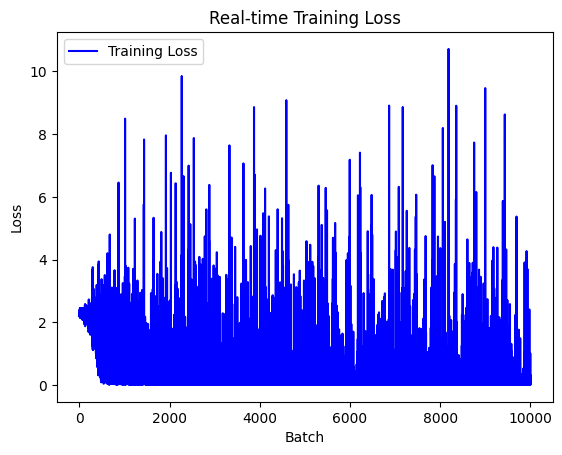

In [173]:
from tqdm import tqdm
# Import torch functional utilities
import torch.nn.functional as F


# Enable interactive mode for plotting
plt.ion()

# Create a figure and axes for the loss curve
fig, ax = plt.subplots()
loss_line, = ax.plot([], [], 'b-', label='Training Loss')  # Create an empty line for the plot
ax.set_xlabel('Batch')
ax.set_ylabel('Loss')
ax.set_title('Real-time Training Loss')
ax.legend()

# Initialize list to store batch loss values for plotting
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
batch_losses = []
num_epochs = 1
num_examples = 10000


for epoch in (range(num_epochs)):
    epoch_loss = 0.0  # Track epoch loss

    last_layer_grad_weights = []
    last_layer_grad_bias = []
    last_layer_output_grads = []
    grad_labels = []
    grad_images_list = []


    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = classifier(images)
        outputs.retain_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Extract gradients of the last layer (fc3)
        last_layer_weights = classifier.fc3.weight
        last_layer_bias = classifier.fc3.bias
        last_layer_grad_weights.extend(last_layer_weights.grad)
        last_layer_grad_bias.extend(last_layer_bias.grad)


        last_layer_output_grads.extend(outputs.grad)
        grad_labels.extend(labels)
        grad_images_list.append(images)

        epoch_loss += loss.item()
        batch_losses.append(loss.item())  # Append batch loss

        # Update plot with current batch loss
        loss_line.set_data(range(len(batch_losses)), batch_losses)
        ax.relim()  # Recompute the data limits
        ax.autoscale_view()  # Autoscale the view
        fig.canvas.draw()
        fig.canvas.flush_events()  # Update the plot in real-time
        if batch_idx > num_examples:
          break


    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    # pdb.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

plt.ioff()  # Turn off interactive mode after training
plt.show()  # Keep the plot window open

After extracting the gradients from the CNN classifier, we can use it to

In [380]:
# for visualization
import os
import numpy as np
import pandas as pd

# Modeling and Machine Learning
from IPython.display import Image
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
########################################

test = torch.cat(last_layer_grad_weights)
test = test.reshape(len(grad_images_list),-1)
grad_images = torch.cat(grad_images_list)

# tsvd = TruncatedSVD(n_components=64).fit_transform(np.asarray(test))
########################################
tsne = TSNE()
transformed = tsne.fit_transform(test)
# # Split up the t-SNE results in training and testing data
tsne_train = pd.DataFrame(transformed, columns=['component1', 'component2'])
tsne_train['labels'] = [int(t) for t in grad_labels]

In [268]:
# from sklearn.metrics import pairwise_distances
# dist = pairwise_distances(test, metric='l2')
# dist = dist.sum(axis=1)

In [381]:
# Standard Libraries
import os
import numpy as np
import pandas as pd

########################################
# !pip install scikit-learn-extra
import numpy as np
import matplotlib.pyplot as plt

from sklearn_extra.cluster import KMedoids


## this is done on ALL of the data, doesn't really scale. need to split this up into smaller chunks
N = 10  # Number of classes (MNIST has 10 digits)
k = k_examples # subset size

kmedoids = KMedoids(n_clusters=k, random_state=0, init='k-medoids++').fit(tsne_train)
# medoids = kmedoids.cluster_centers
medoid_indices = kmedoids.medoid_indices_

In [387]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pylab import *
colors = [matplotlib.colors.rgb2hex(c) for c in plt.cm.plasma(np.linspace(0,1,N))] # plotly hex colormap, N # of discrete colors

set_labels = set(tsne_train['labels'])
tsne_medoids = tsne_train.iloc[medoid_indices]

fig = go.Figure()
for label in set_labels:
  fig.add_trace(go.Scatter(x=tsne_train[tsne_train['labels']==label]['component1'],
                            y=tsne_train[tsne_train['labels']==label]['component2'],
                          #  line=dict(width=2,color=colors[int(label)]),
                            marker=dict(opacity=0.5,color=colors[int(label)]),
                            hovertext=f"Label:{label}",
                            mode='markers', name=int(label), legendgroup=int(label)))

  fig.add_trace(go.Scatter(x=tsne_medoids[tsne_medoids['labels']==label]['component1'],
                            y=tsne_medoids[tsne_medoids['labels']==label]['component2'],
                          #  line=dict(width=2,color=colors[int(label)]),
                            marker=dict(size=12, line=dict(width=2,color='black')),
                            line=dict(width=2,color=colors[int(label)]),
                            hovertext=f"Label:{label}",
                            mode='markers', name=int(label), legendgroup=int(label)))
  x = diameters[diameters['labels']==label]['component1']
  y = diameters[diameters['labels']==label]['component2']



fig.update_layout(
    width=800, height=800,
    template='seaborn',
    xaxis = dict(title="Component 1",
                #  range=[-100,100]
                 ),
    yaxis = dict(title="Component 2",
                #  range=[-100,100]
                 ),
    title='CNN Last Layer Gradient t-SNE plot',
    # legend=dict(groupclick="toggleitem")
)
fig.show()

In [383]:
# # Find the unique cluster labels
# unique_labels = np.unique(tsne_medoids['labels'])
# weights = tsne_medoids.copy()


# # Calculate cluster diameters
# for label in unique_labels:
#     cluster_points = tsne_medoids[tsne_medoids['labels']==label]
#     count = len(cluster_points)
#     distances = pairwise_distances(cluster_points)
#     diameter = np.max(distances)
#     print(f"Cluster {label} diameter: {diameter/count}")
#     weights .loc[diameters['labels'] == label, 'weight'] = diameter/count
# tsne_medoids_test = weights.copy()

Let's train this subset on the CNN now

In [384]:
from torch.utils.data import Dataset, DataLoader # Import the Dataset class
import numpy as np

class ReconstructedMNISTDataset(Dataset):
    def __init__(self, images, labels):
        """
        Args:
            images (list of Tensors): List of reconstructed images as PyTorch Tensors.
            labels (list of int): List of corresponding labels for each image.
        """
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image and label by index
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

k_subset = ReconstructedMNISTDataset(grad_images[medoid_indices], np.asarray(grad_labels)[medoid_indices])
batch_size = 64
sset_loader = DataLoader(k_subset, batch_size=batch_size, shuffle=True)


# Initialize and train the classifier on reconstructed images
classifier = RegularCNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

Epoch [200/200], Loss: 0.0067: 100%|██████████| 200/200 [00:38<00:00,  5.13it/s]


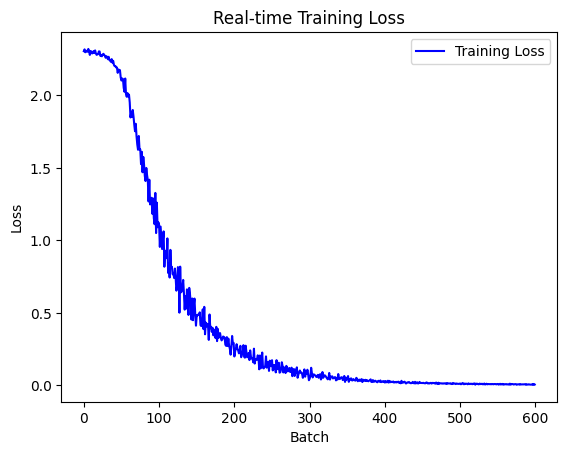

In [385]:
from tqdm import tqdm
# Enable interactive mode for plotting
plt.ion()

# Create a figure and axes for the loss curve
fig, ax = plt.subplots()
loss_line, = ax.plot([], [], 'b-', label='Training Loss')  # Create an empty line for the plot
ax.set_xlabel('Batch')
ax.set_ylabel('Loss')
ax.set_title('Real-time Training Loss')
ax.legend()

# Initialize list to store batch loss values for plotting
batch_losses = []

# Training the classifier on reconstructed images
num_epochs = 200  # You can adjust this as needed
for epoch in (pbar := tqdm(range(num_epochs))):
    epoch_loss = 0.0  # Track epoch loss
    for batch_idx, (images, labels) in enumerate(sset_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_losses.append(loss.item())  # Append batch loss

        # Update plot with current batch loss
        loss_line.set_data(range(len(batch_losses)), batch_losses)
        ax.relim()  # Recompute the data limits
        ax.autoscale_view()  # Autoscale the view
        fig.canvas.draw()
        fig.canvas.flush_events()  # Update the plot in real-time

    avg_epoch_loss = epoch_loss / len(sset_loader)
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

plt.ioff()  # Turn off interactive mode after training
plt.show()  # Keep the plot window open

Test Accuracy of the model on the 10000 test images: 86.65%
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       980
           1       0.99      0.89      0.94      1135
           2       0.90      0.83      0.87      1032
           3       0.89      0.85      0.87      1010
           4       0.93      0.88      0.90       982
           5       0.81      0.83      0.82       892
           6       0.88      0.91      0.90       958
           7       0.84      0.90      0.87      1028
           8       0.72      0.80      0.76       974
           9       0.81      0.80      0.81      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



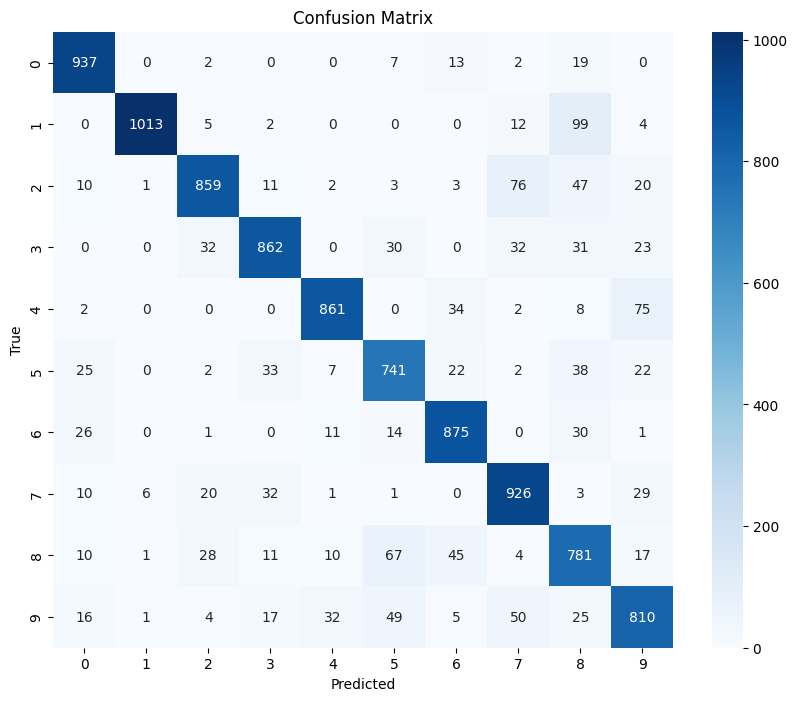

In [386]:
# Load the MNIST test dataset
test_dataset = datasets.MNIST(root=data_path, train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Evaluate the classifier on the real MNIST test set
classifier.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate classification report
print(classification_report(all_labels, all_predictions))

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()